In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import random
import pickle

2025-01-01 04:50:46.034963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-01 04:50:46.195844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-01 04:50:46.243435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 04:50:46.549307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-01 04:50:48.405600: W tensorflow/compiler/tf2

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  8


In [3]:
print(tf.__version__)

2.17.0


In [4]:
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)

In [4]:
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)

In [5]:
train_data = pd.read_csv('sim_compendia_train/5000_runs/sims_compendium_train_file_5000_0.1_0.3_0.6_1.csv')
#train_data = data[data['run']<=500]
eval_data = pd.read_csv('sim_compendia_eval/sims_compendium_train_rand_vol_init_EIR_random_new.csv')
test_data = pd.read_csv('sim_compendia_test/sims_compendium_test_vol_0.1.csv')

In [6]:
#Compendia_5000_runs = glob.glob('sim_compendia_train/5000_runs/*.csv')

#filtered_data = []

#for file in Compendia_5000_runs:
#    df = pd.read_csv(file)
#    df_filtered = df[df['run'] <= 20] # To filter the first 700 runs
#    filtered_data.append(df_filtered)

# All filtered DataFrames into one
#train_data = pd.concat(filtered_data)

In [7]:
# Creating folder to save results
[os.makedirs(dir_name, exist_ok=True) for dir_name in ['src', 'plots', 'metric']]

[None, None, None]

In [8]:
# Log transform function
def log_transform(data):
    return np.log(data)

# Inverse log transform function
def inverse_log_transform(data):
   return np.exp(data)

# Log transforming our data
train_data_scaled = train_data[['prev_true','EIR_true']].apply(log_transform)
eval_data_scaled = eval_data[['prev_true', 'EIR_true']].apply(log_transform)

In [9]:
# Importing sequence function
from sequence_creator import create_sequences

In [10]:
# Creating sequences
window_size = 10
X_train, y_train = create_sequences(train_data_scaled, window_size)
X_eval, y_eval = create_sequences(eval_data_scaled, window_size)

In [11]:
X_train.shape

(1219995, 16, 1)

In [12]:
#Shuffling training Sequences in Unison to introduce more randomness(volatility)
shuffled_indices = np.random.permutation(len(X_train))

X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [13]:
half_window_after = int(np.ceil(window_size / 2))  # Half of the window size, rounded up
seq_length = window_size + 1 + half_window_after

In [15]:
from model import create_model

model = create_model(seq_length)


# model summary
model.summary()

2024-09-30 10:17:19.558133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22054 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:27:00.0, compute capability: 8.6
2024-09-30 10:17:19.559417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22256 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:28:00.0, compute capability: 8.6
2024-09-30 10:17:19.560467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22256 MB memory:  -> device: 2, name: NVIDIA RTX A5000, pci bus id: 0000:43:00.0, compute capability: 8.6
2024-09-30 10:17:19.561450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22256 MB memory:  -> device: 3, name: NVIDIA RTX A5000, pci bus id: 0000:44:00.0, 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16, 200)        │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16, 100)        │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,251 (1.19 MB)

 Trainable params: 312,251 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_eval, y_eval), epochs=15, batch_size=32 )

Epoch 1/15


2024-09-30 10:17:57.000722: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


38125/38125 ━━━━━━━━━━━━━━━━━━━━ 355s 9ms/step - loss: 0.2056 - val_loss: 0.0358
Epoch 2/15
38125/38125 ━━━━━━━━━━━━━━━━━━━━ 342s 9ms/step - loss: 0.0382 - val_loss: 0.0328
Epoch 3/15
38125/38125 ━━━━━━━━━━━━━━━━━━━━ 346s 9ms/step - loss: 0.0318 - val_loss: 0.0322
Epoch 4/15
38125/38125 ━━━━━━━━━━━━━━━━━━━━ 348s 9ms/step - loss: 0.0288 - val_loss: 0.0325
Epoch 5/15
38125/38125 ━━━━━━━━━━━━━━━━━━━━ 346s 9ms/step - loss: 0.0266 - val_loss: 0.0317
Epoch 6/15
38125/38125 ━━━━━━━━━━━━━━━━━━━━ 348s 9ms/step - loss: 0.0253 - val_loss: 0.0308
Epoch 7/15
38125/38125 ━━━━━━━━━━━━━━━━━━━━ 346s 9ms/step - loss: 0.0244 - val_loss: 0.0287
Epoch 8/15
38125/38125 ━━━━━━━━━━━━━━━━━━━━ 349s 9ms/step - loss: 0.0235 - val_loss: 0.0283
Epoch 9/15
38125/38125 ━━━━━━━━━━━━━━━━━━━━ 349s 9ms/step - loss: 0.0229 - val_loss: 0.0288
Epoch 10/15
38125/38125 ━━━━━━━━━━━━━━━━━━━━ 349s 9ms/step - loss: 0.0222 - val_loss: 0.0282
Epoch 11/15
38125/38125 ━━━━━━━━━━━━━━━━━━━━ 348s 9ms/step - loss: 0.0219 - val_loss: 0.02

In [17]:
# Saving the model
model.save('src/lstm_model_assymSeq_shuffled_vol_0.1_0.3_0.6_1_random_init_EIR_5000_W10.keras')

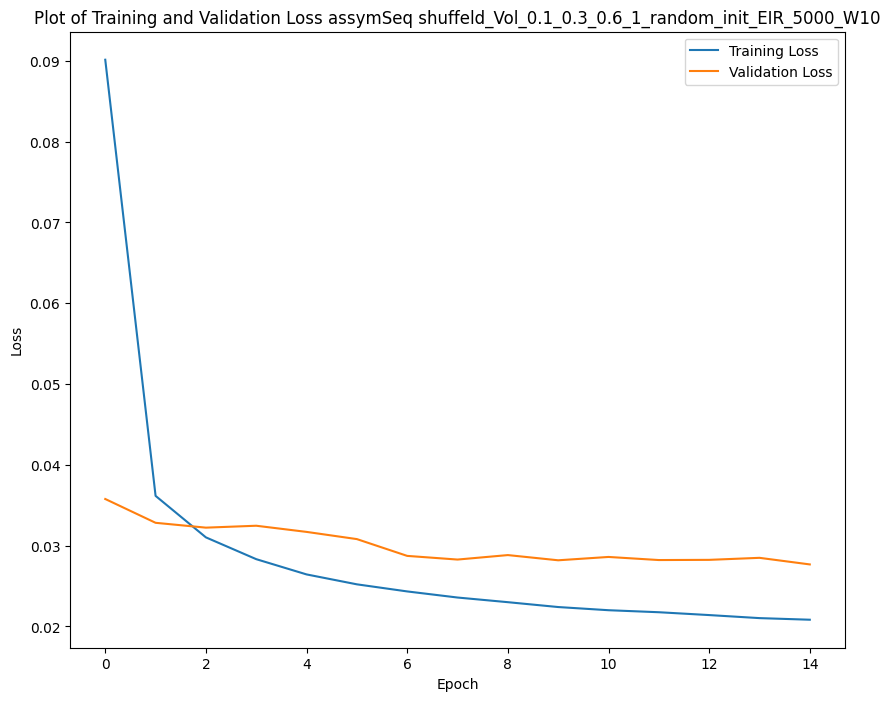

In [18]:
# Training and validation loss plot
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Plot of Training and Validation Loss assymSeq shuffeld_Vol_0.1_0.3_0.6_1_random_init_EIR_5000_W10')
plt.legend()
plt.savefig('metric/training_assymSeq_shuffeld_vol_0.1_0.3_0.6_1_random_init_EIR_5000_W10_loss.png')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


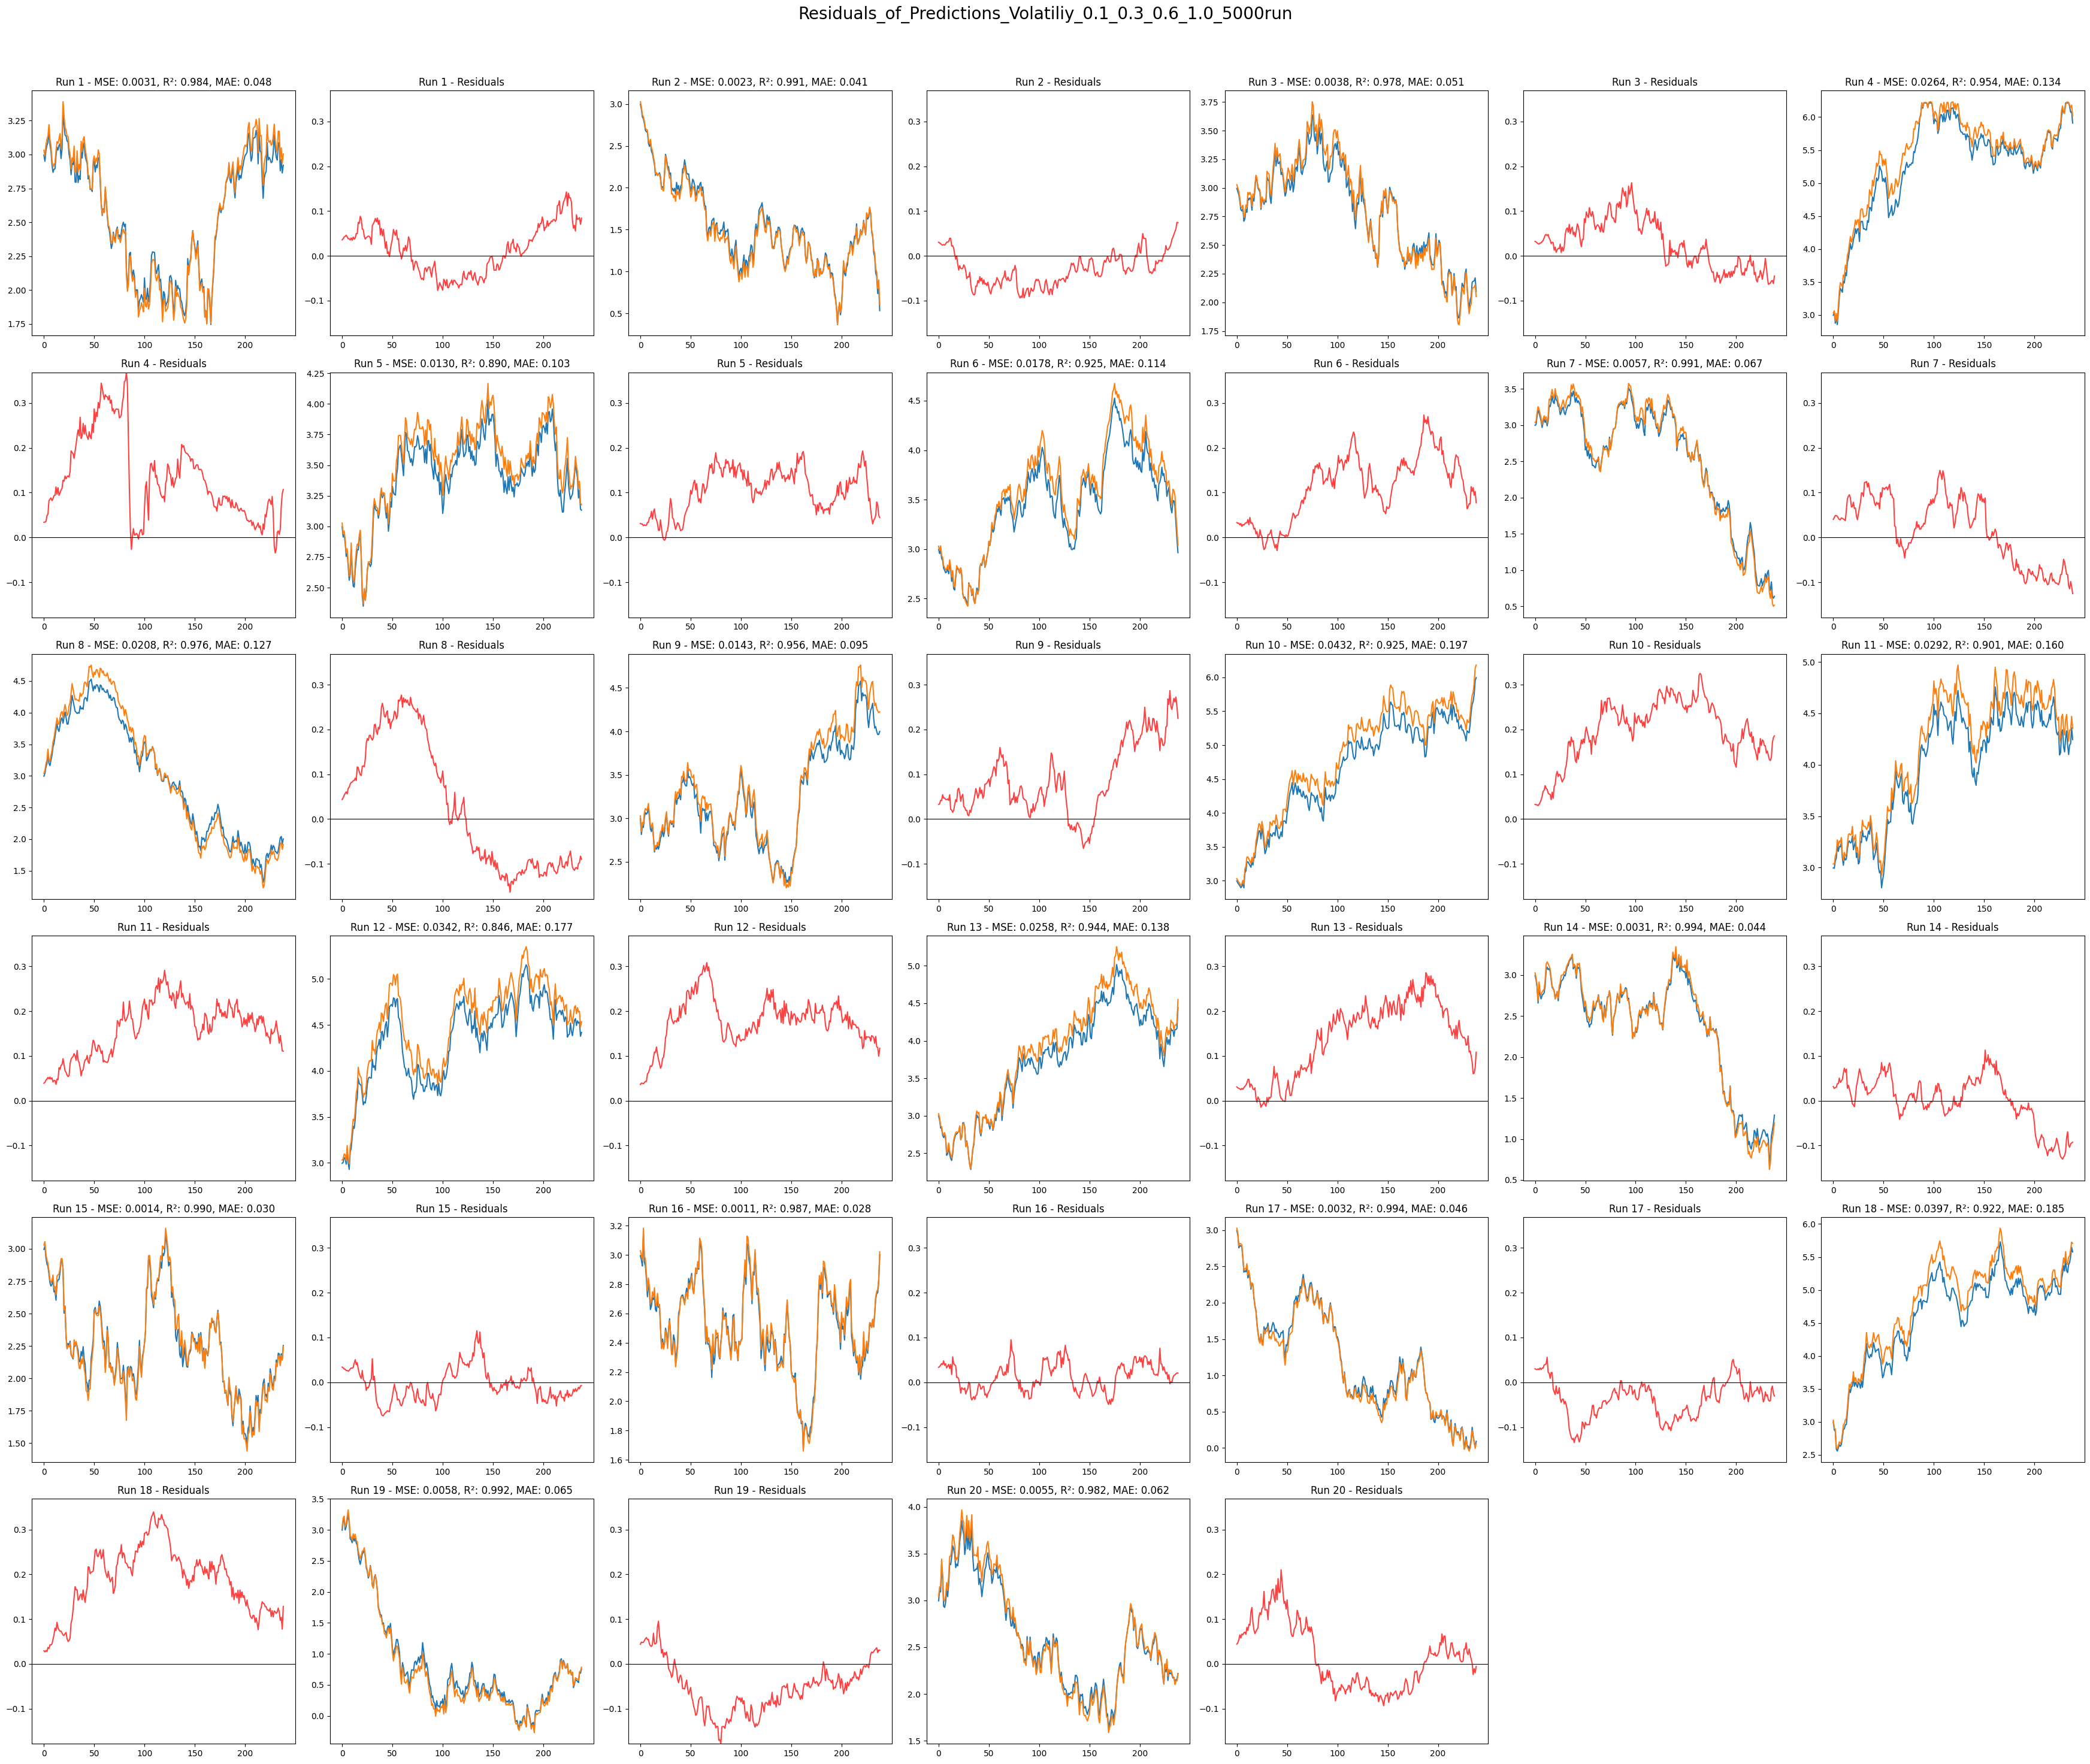

In [19]:
unique_runs = test_data['run'].unique()

# Calculate the number of rows and columns to form a square matrix (or close to it)
num_plots = 2*len(unique_runs)
num_cols = int(np.ceil(np.sqrt(num_plots)))
num_rows = int(np.ceil(num_plots / num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

# Flatten axs only if it is not already 1D
if num_rows * num_cols > 1:
    axs = axs.flatten()

fig.suptitle('Residuals_of_Predictions_Volatiliy_0.1_0.3_0.6_1.0_5000run', fontsize=20)

# Initializing global min and max for residuals
global_min_residual = float('inf')
global_max_residual = float('-inf')

# Store residuals for each run
run_residuals = {}

# Calculate residuals and update global min/max
for run in unique_runs:
    run_data = test_data[test_data['run'] == run]
    scaled_run_data = run_data[['prev_true', 'EIR_true']].apply(log_transform)
    X_test_scaled, y_test_scaled = create_sequences(scaled_run_data, window_size)

    test_predictions_scaled = model.predict(X_test_scaled)

    # Obtain residuals
    residuals = test_predictions_scaled.flatten() - y_test_scaled.flatten()

    # Store residuals for later plotting
    run_residuals[run] = (residuals, y_test_scaled, test_predictions_scaled)

    # Updating global min and max
    global_min_residual = min(global_min_residual, residuals.min())
    global_max_residual = max(global_max_residual, residuals.max())

# Plotting with the same y-axis scale for residuals
for i, run in enumerate(unique_runs):
    residuals, y_test_scaled, test_predictions_scaled = run_residuals[run]

    #True vs predicted Plots
    axs[2 * i].plot(y_test_scaled, label='True EIR_true')
    axs[2 * i].plot(test_predictions_scaled, label='Predicted EIR_true')
    axs[2 * i].set_title(f'Run {run} - True vs Predicted')

    # Residuals Plots
    axs[2 * i + 1].plot(residuals, label='Residuals', color='red', alpha=0.75)
    axs[2 * i + 1].set_title(f'Run {run} - Residuals')
    axs[2 * i + 1].axhline(0, color='black', linewidth=0.8)
    axs[2 * i + 1].set_ylim(global_min_residual, global_max_residual)

    # Metrics for each plot
    mse = mean_squared_error(y_test_scaled, test_predictions_scaled)
    r2 = r2_score(y_test_scaled, test_predictions_scaled)
    mae = mean_absolute_error(y_test_scaled, test_predictions_scaled)
    axs[2 * i].set_title(f'Run {run} - MSE: {mse:.4f}, R²: {r2:.3f}, MAE: {mae:.3f}')


# Removing any empty subplots
for j in range(num_plots, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('plots/residuals_plot_Volatiliy_0.1_0.3_0.6_1.0_5000run.png')
plt.show()

In [20]:
# Evaluating the model
# Training set
y_pred_train = model.predict(X_train)
y_pred_eval = model.predict(X_eval)
mse = mean_squared_error(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
# Test set
test_mse = mean_squared_error(y_eval, y_pred_eval)
test_mae = mean_absolute_error(y_eval, y_pred_eval)
test_r2 = r2_score(y_eval, y_pred_eval)

print(f"Train Mean Squared Error: {mse}")
print(f"Train Mean Absolute Error: {mae}")
print(f"Train R^2 Score: {r2}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean Absolute Error: {test_mae}")
print(f"Test R^2 Score: {test_r2}")

38125/38125 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Mean Squared Error: 0.020727070687302635
Train Mean Absolute Error: 0.09918802450191931
Train R^2 Score: 0.9978593841231421
Test Mean Squared Error: 0.027676304922246497
Test Mean Absolute Error: 0.1058552240462123
Test R^2 Score: 0.9962778600734408
